# WSME-ts

Predict thermostability of single-point mutants with WSME-ts.

## Workflow

I implemented the workflow as follows:

1. **Extract alpha-carbon coordinates from the protein structure** (PDB file).
2. **Compute the native contact map** based on a distance cutoff (used 6Å).
3. **Enumerate folding states** under SSA/DSA and compute the partition function.
4. **Calculate the free-energy landscape**  $F(Q)$ for the WT protein.
5. **Repeat steps 1-4 for each single-point mutant**.
6. **Compare free-energy landscapes of WT and mutants** to predict changes in thermostability.

I used the [**Novozymes Kaggle dataset**](https://www.kaggle.com/code/tranminhthuan/novozymes-eda-modelling-protbert-xgboost) for gettinf the single-point mutant sequences, and their corresponding **$t_m$ values**, and generated mutant structures using [**ESMFold**](https://esmatlas.com/resources?action=fold). The Novozymes dataset includes the sequences and experimentally measured $t_m$ values of single mutants, allowing for model validation.

---

## Application to Predicting Mutant Thermostability

To test our hypothesis, I selected mutants with:
- Lowest $t_m$ (high destabilization)
- Highest $t_m$ (high stabilization)
- $t_m$ similar to WT (neutral effect)

By **comparing their free-energy landscapes to that of the wildtype**, I assessed how well the WSME model captures the energetic shifts induced by mutations. My approach provides a simple, physics-based method to **predict thermostability changes** and can be used as a complementary tool for protein engineering and stability optimization.

---

## References

[1] Ooka K, Liu R, Arai M. The Wako-Saitô-Muñoz-Eaton Model for Predicting Protein Folding and Dynamics. Molecules. (2022) Jul 12;27(14):4460. doi: 10.3390/molecules27144460.

## 1. Model calibration

Here, I test the model on the BdpA protein, which is also analyzed in the reference [1] (page 4). The computed contact map and free-energy landscape obtained using my WSME implementation in DSA mode can be compared to those presented in the reference paper. A qualitative comparison of the free-energy landscapes reveals a similar overall trend: a steep drop at low $Q$, followed by a bump, a broad minimum, and a final increase at high $Q$. However, the reference landscape exhibits a more pronounced bump around $Q≈0.6$, whereas my computed landscape appears flatter in that region.

This discrepancy could arise from an underestimated entropy penalty in my model or from overly uniform contact energy values. The reference model may incorporate a more heterogeneous contact energy matrix, which could better capture the energetic variations contributing to the observed barrier at $Q≈0.6$.

Processing i=0
Processing i=200
Processing i=210
Processing i=220
Processing i=180
Processing i=190
Processing i=160
Processing i=90
Processing i=170
Processing i=140
Processing i=150
Processing i=120
Processing i=70
Processing i=130
Processing i=100
Processing i=50
Processing i=110
Processing i=80
Processing i=30
Processing i=60
Processing i=10
Processing i=40
Processing i=20


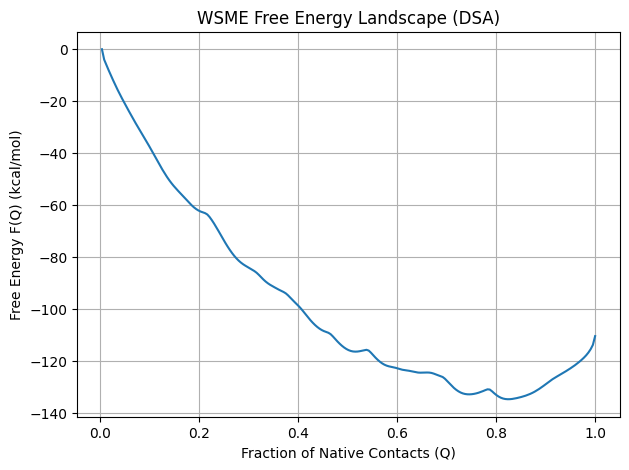

In [1]:
%load_ext autoreload
%autoreload 2

from Bio import PDB
import matplotlib.pyplot as plt
from src.utils import extract_C_alpha, compute_contact_map
from src.wsme import compute_partition_function_Q_SSA, compute_partition_function_Q_DSA, compute_free_energy

DATA_DIR = 'data'

parser = PDB.PDBParser(QUIET=True)
# structure = parser.get_structure("Protein", "data/7urj.pdb")
structure = parser.get_structure("Protein", "data/wt.pdb")

coords, residues = extract_C_alpha(structure)
contact_map = compute_contact_map(coords, cutoff=6.0)

# plt.imshow(contact_map, cmap="gray_r", origin="upper")
# plt.colorbar(label="Contact (1 = Contact, 0 = No Contact)")
# plt.xlabel("Residue Index")
# plt.ylabel("Residue Index")
# plt.show()

Z_Q = compute_partition_function_Q_DSA(contact_map, entropy_penalty=-4./1000, contact_energy = -1.)
Q, F = compute_free_energy(Z_Q, temperature=310)

plt.figure(figsize=(7,5))
plt.plot(Q, F)
plt.xlabel("Fraction of Native Contacts (Q)")
plt.ylabel("Free Energy F(Q) (kcal/mol)")
plt.title("WSME Free Energy Landscape (DSA)")
plt.grid()
# plt.show()

## 2. Predict thermostability

Here below, I compute the free energy for the W and single-point mutant proteins from the Novozymes dataset and store the results in memory. Since these proteins are longer than BdpA and I am running the analysis on a laptop with limited computational power, I used the SSA mode to calculate their free-energy landscapes. This, however, generally results in lower computational cost but may lead to reduced accuracy in capturing folding cooperativity and intermediate states compared to the DSA mode. Despite this trade-off, SSA may still provide a reliable approximation of the free-energy landscapes, allowing for comparison of the thermostability of WT and mutant proteins.

In [ ]:
import os


# Define constants
DATA_DIR = 'data'
TEMP = 300
CUTOFF = 6.0
ENTROPY_PENALTY = -4.5 / 1000
CONTACT_ENERGY = -1.0


free_energy_data = {}

for fname in ["wt.pdb", "low_tm_01.pdb", "low_tm_02.pdb", "low_tm_03.pdb", "low_tm_04.pdb",
              "high_tm_01.pdb", "high_tm_02.pdb", "high_tm_03.pdb", "high_tm_04.pdb",
              "similar_tm_01.pdb", "similar_tm_02.pdb", "similar_tm_03.pdb"]:
    
    print(f'Processing {fname}...')
    fpath = os.path.join(DATA_DIR, fname)
    
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("structure", fpath)
    
    coords, residues = extract_C_alpha(structure)
    contact_map = compute_contact_map(coords, cutoff=CUTOFF)

    Z_Q = compute_partition_function_Q_DSA(contact_map, entropy_penalty=-4./1000, contact_energy = -1.)
    Q, F = compute_free_energy(Z_Q, temperature=310)
    
    free_energy_data[fname] = {
        "Q_values": Q,
        "F_values": F
    }


Processing wt.pdb...
Processing low_tm_01.pdb...
Processing low_tm_02.pdb...
Processing low_tm_03.pdb...
Processing low_tm_04.pdb...
Processing high_tm_01.pdb...
Processing high_tm_02.pdb...
Processing high_tm_03.pdb...
Processing high_tm_04.pdb...
Processing similar_tm_01.pdb...
Processing similar_tm_02.pdb...
Processing similar_tm_03.pdb...


Here below I plot the computed WSME Free Energy Landscapes

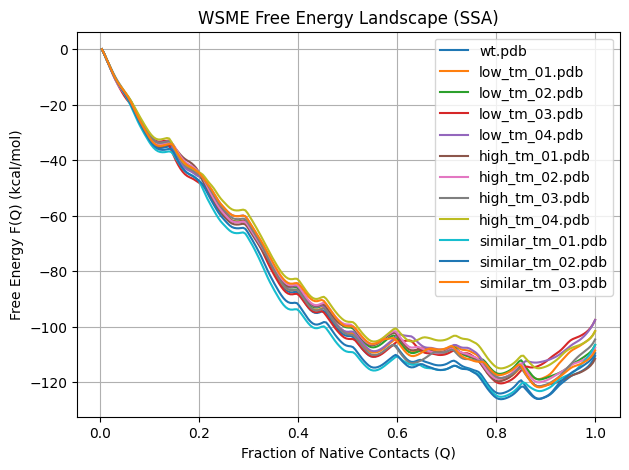

In [16]:
from src.utils import plot_free_energy, plot_free_energy_difference

plot_free_energy(free_energy_data)

Here below, I visualize the free energy difference:

$
\hspace{4cm} \Delta F(Q) = F_{\text{mutant}}(Q) - F_{\text{WT}}(Q)
$

for different groups of single-point mutants: low/high/similar $t_m$ of that of the WT. This comparison helps in assessing the thermostability shifts induced by mutations.

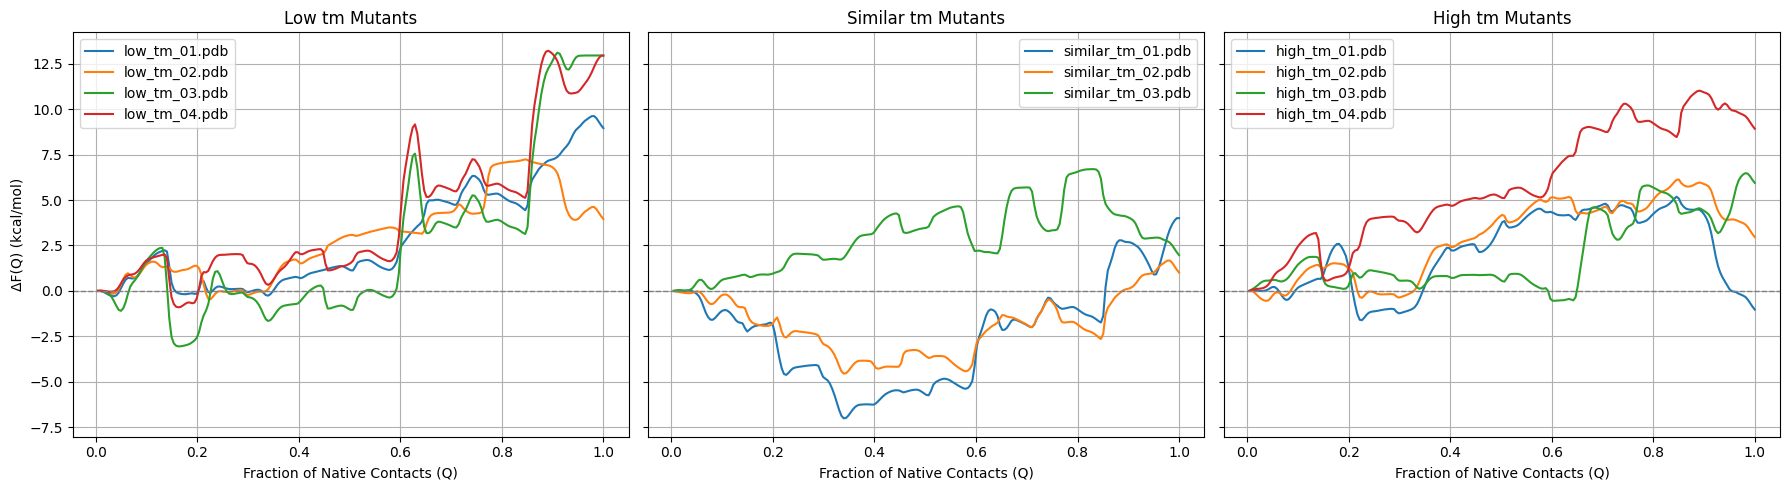

In [17]:
plot_free_energy_difference(free_energy_data)

Here below I compute similarity metrics between the free energy landscapes of WT and mutant proteins. This analysis helps quantify how much each mutation affects the free energy profile, which can be correlated with changes in thermostability. In particular I use RMSD, Pearson correlation, Spearman correlatoin and Dynamic Time Warping to as metrics.

In [18]:
import numpy as np
import pandas as pd
from src.metrics import compute_rmsd, compute_pearson, compute_spearman, compute_dtw


similarity_results = {}

# Get wild-type data
wt_Q = free_energy_data["wt.pdb"]["Q_values"]
wt_F = free_energy_data["wt.pdb"]["F_values"]

for fname, data in free_energy_data.items():
    if fname == "wt.pdb":
        continue  # Skip wild-type

    mutant_Q = data["Q_values"]
    mutant_F = data["F_values"]

    # Ensure arrays have the same length by interpolating mutant_F to match WT Q-values
    mutant_F_interp = np.interp(wt_Q, mutant_Q, mutant_F)

    # Compute similarity metrics
    rmsd = compute_rmsd(wt_F, mutant_F_interp)
    pearson_corr = compute_pearson(wt_F, mutant_F_interp)
    spearman_corr = compute_spearman(wt_F, mutant_F_interp)
    dtw_distance = compute_dtw(wt_F, mutant_F_interp)

    similarity_results[fname] = {
        "RMSD": rmsd,
        "Pearson": pearson_corr,
        "Spearman": spearman_corr,
        "DTW": dtw_distance
    }

df_similarity = pd.DataFrame.from_dict(similarity_results, orient="index")
df_similarity.sort_values('Spearman', ascending=False)

,RMSD,Pearson,Spearman,DTW
high_tm_02.pdb,3.600486,0.999634,0.999271,239.127298
low_tm_02.pdb,3.674308,0.999255,0.998701,261.630693
high_tm_01.pdb,3.009432,0.999004,0.996439,189.040335
similar_tm_03.pdb,3.454742,0.999592,0.995609,155.872751
similar_tm_02.pdb,2.494300,0.998980,0.993803,122.608588
high_tm_04.pdb,6.658497,0.999188,0.992797,501.464703
high_tm_03.pdb,2.815809,0.998860,0.985854,206.642137
similar_tm_01.pdb,3.632187,0.997000,0.985161,145.212182
low_tm_01.pdb,4.071066,0.998118,0.981613,299.945308
low_tm_04.pdb,5.654466,0.996393,0.972245,397.655861


From the results we can observe that:
- Mutants with comparable or higher thermostability to the WT tend to exhibit higher Spearman correlation, suggesting that their rank order of free-energy values across Q-values remains consistent with WT.
- This implies that mutations that preserve the folding pathway and key intermediates tend to maintain stability.
- Conversely, mutants with lower thermostability (potentially destabilizing mutations) show reduced Spearman correlation, indicating significant perturbations in their folding landscape.
- This trend aligns with the hypothesis that free-energy landscape similarity correlates with thermostability, supporting the use of WSME-derived features as predictive markers for stability shifts.

A more accurate prediction would ideally utilize the WSME model in DSA mode. However, due to computational constraints, I was unable to run it within a reasonable timeframe.


Finally, the Free Energy Landscape of selected samples can be examined, revealing the similarity in folding landscapes among high/similar $t_m$ mutants compared to the low $t_m$ mutant.

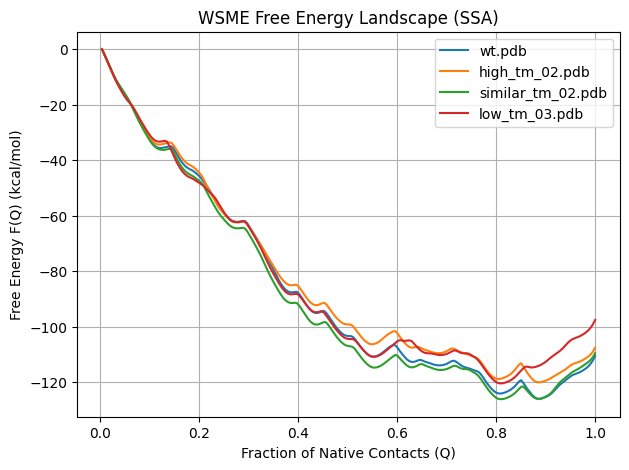

In [19]:
plot_free_energy(free_energy_data, ["wt.pdb", "high_tm_02.pdb", "similar_tm_02.pdb", "low_tm_03.pdb"])